In [15]:
import gc
import numpy as np
from omegaconf import DictConfig
import os
import pandas as pd
import lightning.pytorch as pl
import torch
from tqdm import tqdm
import yaml

from lightning_pose.data.dali import PrepareDALI
from lightning_pose.utils.io import ckpt_path_from_base_path
from lightning_pose.utils.predictions import (
    get_cfg_file, 
    predict_single_video, 
    load_model_from_checkpoint, 
    PredictionHandler,
)
from lightning_pose.utils.scripts import (
    compute_metrics,
    get_imgaug_transform, 
    get_dataset, 
    get_data_module,
)

from eks.utils import convert_lp_dlc, make_output_dataframe, populate_output_dataframe
from eks.singlecam_smoother import ensemble_kalman_smoother_singlecam

from pseudo_labeler.utils import format_data_walk
from pseudo_labeler.evaluation import compute_likelihoods_and_variance

dataset_name = "mirror-mouse"
n_hand_labels = 100
n_pseudo_labels = 1000
seeds=[0, 1, 2, 3, 4]
selection_strategy="random"
# dataset_name = "mirror-fish"
# dataset_name = "crim13"

# where the labeled data is stored
data_dir = f"/teamspace/studios/this_studio/data/{dataset_name}"

# where the video snippets are stored
snippets_dir = f"{data_dir}/videos-for-each-labeled-frame"

# where the network models are stored
networks_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/networks"

# where to save eks/post-processor outputs
eks_save_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/post-processors/eks_rng={seeds[0]}-{seeds[-1]}/eks_ood_snippets"

aeks_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/results_aeks_random"

# where to save aeks_eks outputs
aeks_eks_save_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/results_aeks/eks_rng={seeds[0]}-{seeds[-1]}"

# where model configs are stored
config_dir = f"/teamspace/studios/this_studio/keypoint-pseudo-labeler/configs/"

# file name of csv where marker data is stored
ground_truth_csv = 'CollectedData_new.csv'



In [13]:

def find_model_dirs(base_dir, keyword):
    model_dirs = []
    for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            if keyword in dir_name:
                model_dirs.append(os.path.join(root, dir_name))
    return model_dirs

model_dirs_list = []
if dataset_name == "mirror-mouse":
    model_dirs_list = find_model_dirs(networks_dir, 'rng')
    print(f"Found {len(model_dirs_list)} model directories")
    keypoint_ensemble_list = [
        'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'nose_top', 'tailBase_top', 'tailMid_top',
        'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'nose_bot', 'tailBase_bot', 'tailMid_bot',
    ]
else:
    raise NotImplementedError


Found 5 model directories


## Helper Functions:

In [8]:
def process_csv_for_sessions_and_frames(ground_truth_df):
    session_frame_info = []
    for idx, row in tqdm(ground_truth_df.iterrows(), total=len(ground_truth_df)):
        first_col_value = row[0]
        path_parts = first_col_value.split('/')
        session = path_parts[1]
        frame = path_parts[2]
        session_frame_info.append((session, frame))
    return session_frame_info

## Step 1: run inference on video snippets

In [9]:
def run_inference_on_snippets(model_dirs_list, data_dir, snippets_dir, ground_truth_df):
    trainer = pl.Trainer(accelerator="gpu", devices=1)
    session_frame_info = process_csv_for_sessions_and_frames(ground_truth_df)
    
    for model_dir in model_dirs_list:
        print(f'Processing model in {os.path.basename(model_dir)}')
        cfg_file = os.path.join(model_dir, "config.yaml")
        model_cfg = DictConfig(yaml.safe_load(open(cfg_file)))
        
        # Update data directories
        model_cfg.data.data_dir = data_dir
        model_cfg.data.video_dir = os.path.join(data_dir, "videos")
        
        # Get model checkpoint
        ckpt_file = ckpt_path_from_base_path(model_dir, model_name=model_cfg.model.model_name)
        
        # Build datamodule
        cfg_new = model_cfg.copy()
        cfg_new.training.imgaug = 'default'
        imgaug_transform = get_imgaug_transform(cfg=cfg_new)
        dataset_new = get_dataset(cfg=cfg_new, data_dir=cfg_new.data.data_dir, imgaug_transform=imgaug_transform)
        datamodule_new = get_data_module(cfg=cfg_new, dataset=dataset_new, video_dir=cfg_new.data.video_dir)
        datamodule_new.setup()
        
        # Load model
        model = load_model_from_checkpoint(cfg=cfg_new, ckpt_file=ckpt_file, eval=True, data_module=datamodule_new)
        model.to("cuda")
        
        model_cfg.dali.base.sequence_length = 16

        for session, frame in tqdm(session_frame_info):
            video_file = os.path.join(snippets_dir, session, frame.replace('png', 'mp4'))
            prediction_csv_file = os.path.join(model_dir, "video_preds_labeled", session, frame.replace('png', 'csv'))
            os.makedirs(os.path.join(model_dir, "video_preds_labeled", session), exist_ok=True)
            
            if not os.path.exists(video_file):
                print(f'Cannot find video snippet for {video_file}. Skipping')
                continue
            if os.path.exists(prediction_csv_file):
                print(f'Prediction csv file already exists for {session}/{frame}. Skipping')
                continue
            
            print(f'{video_file} saved as\n{prediction_csv_file}')
            cfg = get_cfg_file(cfg_file=cfg_new)
            model_type = "context" if cfg.model.model_type == "heatmap_mhcrnn" else "base"
            cfg.training.imgaug = "default"
            
            vid_pred_class = PrepareDALI(
                train_stage="predict",
                model_type=model_type,
                dali_config=cfg.dali,
                filenames=[video_file],
                resize_dims=[cfg.data.image_resize_dims.height, cfg.data.image_resize_dims.width]
            )
            
            # Get loader
            predict_loader = vid_pred_class()
            
            # Initialize prediction handler class
            pred_handler = PredictionHandler(cfg=cfg, data_module=datamodule_new, video_file=video_file)
            
            # Compute predictions
            preds = trainer.predict(model=model, dataloaders=predict_loader, return_predictions=True)
            
            # Process predictions
            preds_df = pred_handler(preds=preds)
            os.makedirs(os.path.dirname(prediction_csv_file), exist_ok=True)
            preds_df.to_csv(prediction_csv_file)
            
            # Clear up memory
            del predict_loader
            del pred_handler
            del vid_pred_class
            gc.collect()
            torch.cuda.empty_cache()
        
        del dataset_new
        del datamodule_new
        del model
        gc.collect()
        torch.cuda.empty_cache()

In [10]:
ground_truth_df = pd.read_csv(os.path.join(data_dir, ground_truth_csv), skiprows=2)
run_inference_on_snippets(model_dirs_list, data_dir, snippets_dir, ground_truth_df)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 253/253 [00:00<00:00, 10383.16it/s]

Processing model in rng1
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 100
Warning! Requested training frames exceeds training set size; using all
Dataset splits -- train: 80, val: 10, test: 10

 Initializing a HeatmapTracker instance.


100%|██████████| 253/253 [00:00<00:00, 26242.28it/s]


Prediction csv file already exists for 180607_004/img015278.png. Skipping
Prediction csv file already exists for 180607_004/img015320.png. Skipping
Prediction csv file already exists for 180607_004/img015814.png. Skipping
Prediction csv file already exists for 180607_004/img015879.png. Skipping
Prediction csv file already exists for 180607_004/img016209.png. Skipping
Prediction csv file already exists for 180607_004/img016400.png. Skipping
Prediction csv file already exists for 180607_004/img016437.png. Skipping
Prediction csv file already exists for 180607_004/img016434.png. Skipping
Prediction csv file already exists for 180607_004/img016429.png. Skipping
Prediction csv file already exists for 180607_004/img016542.png. Skipping
Prediction csv file already exists for 180607_004/img016558.png. Skipping
Prediction csv file already exists for 180607_004/img016635.png. Skipping
Prediction csv file already exists for 180607_004/img016630.png. Skipping
Prediction csv file already exists for

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prediction csv file already exists for 180607_004/img015278.png. Skipping
Prediction csv file already exists for 180607_004/img015320.png. Skipping
Prediction csv file already exists for 180607_004/img015814.png. Skipping
Prediction csv file already exists for 180607_004/img015879.png. Skipping
Prediction csv file already exists for 180607_004/img016209.png. Skipping
Prediction csv file already exists for 180607_004/img016400.png. Skipping
Prediction csv file already exists for 180607_004/img016437.png. Skipping
Prediction csv file already exists for 180607_004/img016434.png. Skipping
Prediction csv file already exists for 180607_004/img016429.png. Skipping
Prediction csv file already exists for 180607_004/img016542.png. Skipping
Prediction csv file already exists for 180607_004/img016558.png. Skipping
Prediction csv file already exists for 180607_004/img016635.png. Skipping
Prediction csv file already exists for 180607_004/img016630.png. Skipping
Prediction csv file already exists for

Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img235530.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_000/img235530.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img250883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_000/img250883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img081243.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img081243.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img091145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img091145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img103612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img103612.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img109036.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img109036.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img130158.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img130158.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img146879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img146879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img163809.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img163809.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img168800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img168800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img176505.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img176505.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img196983.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img196983.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img200918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img200918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img219119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img219119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img227562.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img227562.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img244262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img244262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img247495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img247495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img253420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img253420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img284725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img284725.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img301935.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img301935.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img309374.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img309374.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img313791.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img313791.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img317922.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img317922.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img338587.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180609_004/img338587.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img032005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032067.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img032067.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032167.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img032167.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img033632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img033632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img034389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034466.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img034466.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034657.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img034657.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034709.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img034709.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img034698.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035021.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img035021.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035409.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img035409.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img035482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img035725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036295.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036295.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036833.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036833.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img036918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037075.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img037075.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037070.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img037070.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037341.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img037341.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037719.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img037719.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038325.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img038325.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038944.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img038944.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038959.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img038959.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038989.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img038989.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039146.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img039146.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039473.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img039473.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img041737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img041737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042292.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042292.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042393.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042393.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042487.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042487.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042633.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042633.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042915.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042915.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042985.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img042985.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img043415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img043415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044000.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044000.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044095.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044095.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044091.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044091.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044306.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044306.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044460.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044460.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044490.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044490.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044549.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044549.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044566.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044566.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044661.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img044661.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045297.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045297.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045514.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045514.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045629.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045629.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045672.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045672.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045870.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img045870.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046022.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046022.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046521.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046521.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046553.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046553.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046597.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046597.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046745.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046745.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046848.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img046848.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img048585.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img048585.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049423.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049423.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049525.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049582.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049582.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049614.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049614.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049742.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049742.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049973.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img049973.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050088.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img050088.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050895.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img050895.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050896.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img050896.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050899.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180613_000/img050899.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023658.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img023658.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023660.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img023660.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023662.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img023662.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023720.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img023720.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100264.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100264.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100417.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100417.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100470.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100470.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100476.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100484.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100484.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100572.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100572.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100737.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100901.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img100901.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img102822.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img102822.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103326.csv


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103450.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103450.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103467.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103467.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103469.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103469.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103472.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103472.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103541.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img103541.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img104593.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds_labeled/180623_000/img104593.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 238/253 [03:07<00:11,  1.27it/s]


TypeError: 'NoneType' object is not iterable

## Step 2: run EKS

In [ ]:
def run_eks_on_snippets(snippets_dir, model_dirs_list, eks_save_dir, ground_truth_df):
    session_frame_info = process_csv_for_sessions_and_frames(ground_truth_df)
    tracker_name = 'heatmap_tracker'
    keypoint_names = None

    # store useful info here
    index_list = []
    results_list = []

    # Step 1: Process and save the CSVs
    for session, frame in session_frame_info:
        # extract all markers
        markers_list = []
        for model_dir in model_dirs_list:
            csv_file = os.path.join(
                model_dir, 'video_preds_labeled', session, frame.replace('png', 'csv'))
            df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
            keypoint_names = [l[1] for l in df_tmp.columns[::3]]
            markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
            markers_list.append(markers_tmp)

        dfs_markers = markers_list
        # make empty dataframe to write results into
        df_eks = make_output_dataframe(df_tmp)

        # Convert list of DataFrames to a 3D NumPy array
        data_arrays = [df.to_numpy() for df in markers_list]
        markers_3d_array = np.stack(data_arrays, axis=0)

        # Map keypoint names to keys in input_dfs and crop markers_3d_array
        keypoint_is = {}
        keys = []
        for i, col in enumerate(markers_list[0].columns):
            keypoint_is[col] = i
        for part in keypoint_ensemble_list:
            keys.append(keypoint_is[part + '_x'])
            keys.append(keypoint_is[part + '_y'])
            keys.append(keypoint_is[part + '_likelihood'])
        key_cols = np.array(keys)
        markers_3d_array = markers_3d_array[:, :, key_cols]

        save_dir = os.path.join(eks_save_dir, 'eks', session)
        save_file = os.path.join(save_dir, frame.replace('png', 'csv'))
        if os.path.exists(save_file):
            print(f'Skipping ensembling for {session}/{frame} as it already exists.')
            continue
        else:
            print(f'Ensembling for {session}/{frame}')
            # Call the smoother function
            df_dicts, s_finals = ensemble_kalman_smoother_singlecam(
                markers_3d_array,
                keypoint_ensemble_list,
                smooth_param=None,
                s_frames=[(None, None)],
                blocks=[],
            )
            # put results into new dataframe
            for k, keypoint_name in enumerate(keypoint_ensemble_list):
                keypoint_df = df_dicts[k][keypoint_name + '_df']
                df_eks = populate_output_dataframe(keypoint_df, keypoint_name, df_eks)

            # save eks results
            os.makedirs(save_dir, exist_ok=True)
            df_eks.to_csv(save_file)

    # Step 2: Extract center frame results
    print('Extracting center frame results from all sessions.')
    for session, frame in session_frame_info:
        # Construct the path to the saved EKS results
        save_file = os.path.join(eks_save_dir, 'eks', session, frame.replace('png', 'csv'))
        if not os.path.exists(save_file):
            print(f'Missing EKS file for {session}/{frame}. Skipping.')
            continue

        # read csv
        df_eks = pd.read_csv(save_file, header=[0, 1, 2], index_col=0)
        
        # extract result from center frame
        assert df_eks.shape[0] & 2 != 0
        idx_frame = int(np.floor(df_eks.shape[0] / 2))
        frame_file = frame.replace('.mp4', '.png')
        index_name = f'labeled-data/{session}/{frame_file}'
        result = df_eks[df_eks.index == idx_frame].rename(index={idx_frame: index_name})
        results_list.append(result)

    # save final predictions
    results_df = pd.concat(results_list)
    results_df.sort_index(inplace=True)
    # add "set" column so this df is interpreted as labeled data predictions
    results_df.loc[:, ("set", "", "")] = "train"
    results_df.to_csv(os.path.join(eks_save_dir, 'eks', 'predictions_new.csv'))

    return df_eks, dfs_markers

In [ ]:
df_eks, dfs_markers = run_eks_on_snippets(snippets_dir, model_dirs_list, eks_save_dir, ground_truth_df)

In [ ]:
print(len(dfs_markers))

## Step 2.5: sanity check EKS dfs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

def plot_eks_dfs(keypoint_ensemble_list, markers_list, df_eks):
    """
    Plots the EKS DataFrames for the given keypoints.

    Parameters:
    - keypoint_ensemble_list: List of keypoints to plot.
    - markers_list: List of DataFrames containing marker data.
    - df_eks: DataFrame containing the ensemble kalman smoother results.
    """
    for kp in keypoint_ensemble_list:
        fig, axes = plt.subplots(2, 1, figsize=(12, 6))
        for ax, coord in zip(axes, ['x', 'y']):
            cols0 = (f'{kp}_{coord}')
            cols1 = ('ensemble-kalman_tracker', kp, coord)
            for i, df in enumerate(markers_list):
                m = df.loc[:, cols0]
                color = [0.5, 0.5, 0.5] # if i < 5 else [0, 0, 1]  # Use grey for rng0-4 and red for rng5 and beyond
                ax.plot(m.to_numpy(), color=color)
            m = df_eks.loc[:, cols1]
            ax.plot(m, color='k')
            ax.set_title(cols0)
        plt.show()

In [ ]:
plot_eks_dfs(keypoint_ensemble_list, dfs_markers, df_eks)

## Step 3: compute ens mean/median

### collect predictions from individual models

In [ ]:
def collect_preds(model_dirs_list, snippets_dir):
    for model_dir in tqdm(model_dirs_list):
        results_list = []
        sessions = os.listdir(snippets_dir)
        for session in sessions:
            frames = os.listdir(os.path.join(snippets_dir, session))
            for frame in frames:
                # Load prediction on snippet
                df = pd.read_csv(
                    os.path.join(model_dir, 'video_preds_labeled', session, frame.replace('.mp4', '.csv')), 
                    header=[0, 1, 2], 
                    index_col=0,
                )
                # Extract result from center frame
                assert df.shape[0] & 2 != 0
                idx_frame = int(np.floor(df.shape[0] / 2))
                frame_file = frame.replace('.mp4', '.png')
                index_name = f'labeled-data/{session}/{frame_file}'
                result = df[df.index == idx_frame].rename(index={idx_frame: index_name})
                results_list.append(result)

        # Save final predictions
        results_df = pd.concat(results_list)
        results_df.sort_index(inplace=True)
        # Add "set" column so this df is interpreted as labeled data predictions
        results_df.loc[:, ("set", "", "")] = "train"
        results_df.to_csv(os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv'))



In [ ]:
collect_preds(model_dirs_list, snippets_dir)

### compute ens mean/median

In [ ]:
def compute_ens_mean_median(model_dirs_list, eks_save_dir, post_processor_type):
    markers_list = []
    for model_dir in model_dirs_list:
        csv_file = os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv')
        df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
        preds_curr = df_tmp.to_numpy()[:, :-1]  # remove "set" column
        preds_curr = np.delete(preds_curr, list(range(2, preds_curr.shape[1], 3)), axis=1)
        preds_curr = np.reshape(preds_curr, (preds_curr.shape[0], -1, 2))
        markers_list.append(preds_curr[..., None])
    
    # Concatenate across last dim
    pred_arrays = np.concatenate(markers_list, axis=3)
    
    # Compute mean/median across x/y
    if post_processor_type == 'ens-mean':
        ens_mean = np.mean(pred_arrays, axis=3)
    elif post_processor_type == 'ens-median':
        ens_mean = np.median(pred_arrays, axis=3)
    
    ens_likelihood = np.nan * np.zeros((ens_mean.shape[0], ens_mean.shape[1], 1))
    
    # Build dataframe
    xyl = np.concatenate([ens_mean, ens_likelihood], axis=2)
    df_final = pd.DataFrame(
        xyl.reshape(ens_mean.shape[0], -1), 
        columns=df_tmp.columns[:-1],  # remove "set" column, add back in later
        index=df_tmp.index
    )
    df_final.sort_index(inplace=True)
    # Add "set" column so this df is interpreted as labeled data predictions
    df_final.loc[:, ("set", "", "")] = "train"
    save_dir_ = os.path.join(eks_save_dir, f'{post_processor_type}')
    os.makedirs(save_dir_, exist_ok=True)
    df_final.to_csv(os.path.join(save_dir_, 'predictions_new.csv'))

In [ ]:
compute_ens_mean_median(model_dirs_list, eks_save_dir, 'ens-mean')
compute_ens_mean_median(model_dirs_list, eks_save_dir, 'ens-median')

## Step 4: compute metrics

### step 4.1: create data module to have access to labeled data

In [ ]:
cfg_file = os.path.join(config_dir, f"config_{dataset_name}.yaml")
cfg = DictConfig(yaml.safe_load(open(cfg_file)))

model_cfg = cfg.copy()

model_cfg.data.data_dir = data_dir
model_cfg.data.csv_file = ground_truth_csv

model_cfg.training.imgaug = "default"
model_cfg.training.train_prob = 1
model_cfg.training.val_prob = 0
model_cfg.training.train_frames = 1

imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(
    cfg=model_cfg, 
    data_dir=model_cfg.data.data_dir, 
    imgaug_transform=imgaug_transform)
data_module = get_data_module(
    cfg=model_cfg, 
    dataset=dataset, 
    video_dir=os.path.join(data_dir, dataset_name, "videos"))
data_module.setup()

### step 4.2: compute metrics on ensemble members

In [ ]:
for model_dir in model_dirs_list:
    print(model_dir)
    preds_file = os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)


### step 4.3: compute metrics on post-processed traces

In [ ]:
post_processor_types = [
    "ens-mean",
    "ens-median",
    "eks",
]

for post_processor_type in post_processor_types:
    print(f'{post_processor_type}')
    preds_file = os.path.join(eks_save_dir, f'{post_processor_type}', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)


## Step 5: run everything again with expanded dataset

In [ ]:
model_dirs_list = []
if dataset_name == "mirror-mouse":
    model_dirs_list = find_model_dirs(aeks_dir, 'rng')
    keypoint_ensemble_list = [
        'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'nose_top', 'tailBase_top', 'tailMid_top',
        'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'nose_bot', 'tailBase_bot', 'tailMid_bot',
    ]
else:
    raise NotImplementedError

# remove eks_rng=0-3
for directory in model_dirs_list:
    if 'eks' in os.path.basename(directory):
        print(f"{directory} has 'eks' in it. Removing")
        model_dirs_list.remove(directory)
print(f"Found {len(model_dirs_list)} model directories")

# 1. running inference
run_inference_on_snippets(model_dirs_list, data_dir, snippets_dir, ground_truth_df)

# 2. running EKS
df_eks, dfs_markers = run_eks_on_snippets(snippets_dir, model_dirs_list, aeks_eks_save_dir, ground_truth_df)

# 3.1 collect preds from aeks models
collect_preds(model_dirs_list, snippets_dir)
# 3.2 compute ens mean and median
compute_ens_mean_median(model_dirs_list, aeks_eks_save_dir, 'ens-mean')
compute_ens_mean_median(model_dirs_list, aeks_eks_save_dir, 'ens-median')

In [ ]:
# 4

# 4.1 Create Data Module
cfg_file = os.path.join(config_dir, f"config_{dataset_name}.yaml")
cfg = DictConfig(yaml.safe_load(open(cfg_file)))

model_cfg = cfg.copy()

model_cfg.data.data_dir = data_dir
model_cfg.data.csv_file = ground_truth_csv

model_cfg.training.imgaug = "default"
model_cfg.training.train_prob = 1
model_cfg.training.val_prob = 0
model_cfg.training.train_frames = 1

imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(
    cfg=model_cfg, 
    data_dir=model_cfg.data.data_dir, 
    imgaug_transform=imgaug_transform)
data_module = get_data_module(
    cfg=model_cfg, 
    dataset=dataset, 
    video_dir=os.path.join(data_dir, dataset_name, "videos"))
data_module.setup()

# 4.2 compute metrics on aEKS ensemble members
for model_dir in model_dirs_list:
    print(model_dir)
    preds_file = os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)

# 4.3 compute metric on post-processed traces
post_processor_types = [
    "ens-mean",
    "ens-median",
    "eks",
]

for post_processor_type in post_processor_types:
    print(f'{post_processor_type}')
    preds_file = os.path.join(aeks_eks_save_dir, f'{post_processor_type}', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)

### step 5.1: calculate ensemble variance

In [20]:
# load ground truth data, for ensuring indices match
df_gt = pd.read_csv(os.path.join(data_dir, 'CollectedData_new.csv'), header=[0, 1, 2], index_col=0)
df_gt.sort_index(inplace=True)

aeks_hand_dir = os.path.join(aeks_dir, '../results_aeks_hand')

data_to_plot = {
    'networks_rng0': os.path.join(networks_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
    'networks_rng1': os.path.join(networks_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
    'networks_rng2': os.path.join(networks_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
    'networks_rng3': os.path.join(networks_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
    'networks_rng4': os.path.join(networks_dir, 'rng4/video_preds_labeled/predictions_new.csv'),
    #'networks_rng6': os.path.join(networks_dir, 'rng6/video_preds_labeled/predictions_new.csv'),
    #'networks_rng5': os.path.join(networks_dir, 'rng5/video_preds_labeled/predictions_new.csv'),
    #'networks_rng7': os.path.join(networks_dir, 'rng7/video_preds_labeled/predictions_new.csv'),
    #'networks_rng8': os.path.join(networks_dir, 'rng8/video_preds_labeled/predictions_new.csv'),
    #'networks_rng9': os.path.join(networks_dir, 'rng9/video_preds_labeled/predictions_new.csv'),
    'eks': os.path.join(eks_save_dir, 'eks/predictions_new.csv'),
    #'ens-mean': os.path.join(eks_save_dir, 'ens-mean/predictions_new.csv'),
    #'ens-median': os.path.join(eks_save_dir, 'ens-median/predictions_new.csv'),
    #'aeks_random_rng0': os.path.join(aeks_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
    #'aeks_random_rng1': os.path.join(aeks_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
    #'aeks_random_rng2': os.path.join(aeks_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
    #'aeks_random_rng3': os.path.join(aeks_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
    #'aeks_random_eks': os.path.join(aeks_dir, 'eks_rng=0-3/eks/predictions_new.csv'),
    #'aeks_hand_rng0': os.path.join(aeks_hand_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
    #'aeks_hand_rng1': os.path.join(aeks_hand_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
    #'aeks_hand_rng2': os.path.join(aeks_hand_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
    #'aeks_hand_rng3': os.path.join(aeks_hand_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
    #'aeks_hand_eks': os.path.join(aeks_hand_dir, 'eks_rng=0-3/eks/predictions_new.csv'),
    #'aeks_ens-mean': os.path.join(aeks_dir, 'eks_rng=0-3/ens-mean/predictions_new.csv'),
    #'aeks_ens-median': os.path.join(aeks_dir, 'eks_rng=0-3/ens-median/predictions_new.csv'),
}

# define predictions so we can compute ensemble variance
pred_csv_list = []
# define model names
model_names_list = []
# reformat
for key, val in data_to_plot.items():
    model_names_list.append(key)
    pred_csv_list.append(val)

# define pixel error to plot
error_csv_list = [p.replace('.csv', '_pixel_error.csv') for p in pred_csv_list]

# load data
df_pred_list = []
df_error_list = []
for pred_csv, error_csv in zip(pred_csv_list, error_csv_list):
#     df_pred_list.append(pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).drop(columns=['set']))
#     df_error_list.append(pd.read_csv(error_csv, header=[0], index_col=0).drop(columns=['set']))
    
    df_pred_list.append(pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).sort_index())
    df_error_list.append(pd.read_csv(error_csv, header=[0], index_col=0).drop(columns=['set']).sort_index())

In [21]:
import numpy as np
import pandas as pd

def standardize_scorer_level(df, new_scorer='standard_scorer'):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names
    )
    return df

def compute_ensemble_stddev(
    df_ground_truth,
    df_preds,
    keypoint_ensemble_list,
    scorer_name='standard_scorer'
):
    """
    Parameters
    ----------
    df_ground_truth : List[pd.DataFrame]
        ground truth predictions
    df_preds : List[pd.DataFrame]
        model predictions
    keypoint_ensemble_list : List[str]
        keypoints to include in the analysis

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")

    preds = []
    cols_order = None
    for i, df in enumerate(df_preds):
        assert np.all(df.index == df_ground_truth.index), f"Index mismatch between ground truth and predictions at dataframe {i}"
        
        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)
        
        # Remove likelihood columns
        cols_to_keep = [col for col in df.columns if not col[2].endswith('_likelihood') and 'zscore' not in col[2]]
        # Keep only columns matching the keypoint_ensemble_list
        cols_to_keep = [col for col in cols_to_keep if col[1] in keypoint_ensemble_list]
        df = df[cols_to_keep]
        
        print(f"DataFrame {i} kept columns:", df.columns)
        
        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")
        
        # Print the order of the column headers
        if cols_order is None:
            cols_order = df.columns
        else:
            if not (df.columns == cols_order).all():
                print(f"Column order mismatch detected in DataFrame {i}")
                print("Expected order:", cols_order)
                print("Actual order:", df.columns)
                # Ensure bodyparts and coordinates are consistent
                expected_bodyparts_coords = cols_order.droplevel(0).unique()
                actual_bodyparts_coords = df.columns.droplevel(0).unique()
                if not expected_bodyparts_coords.equals(actual_bodyparts_coords):
                    print("Bodyparts and coordinates mismatch detected")
                    print("Expected bodyparts and coordinates:", expected_bodyparts_coords)
                    print("Actual bodyparts and coordinates:", actual_bodyparts_coords)
        
        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise
        
        preds.append(arr[..., None])
    
    preds = np.concatenate(preds, axis=3)
    
    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")
    
    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    print(f"Stddevs: {stddevs}")
    return stddevs

def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(p_)
    return vals, prctiles

def cleanaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=False)
    ax.tick_params(right=False)


In [22]:
# compute ensemble variance
ens_stddev = compute_ensemble_stddev(
    df_gt,
    df_pred_list,
    keypoint_ensemble_list
)

DataFrame 0 kept columns: MultiIndex([('standard_scorer',   'paw1LH_top',          'x'),
            ('standard_scorer',   'paw1LH_top',          'y'),
            ('standard_scorer',   'paw1LH_top', 'likelihood'),
            ('standard_scorer',   'paw2LF_top',          'x'),
            ('standard_scorer',   'paw2LF_top',          'y'),
            ('standard_scorer',   'paw2LF_top', 'likelihood'),
            ('standard_scorer',   'paw3RF_top',          'x'),
            ('standard_scorer',   'paw3RF_top',          'y'),
            ('standard_scorer',   'paw3RF_top', 'likelihood'),
            ('standard_scorer',   'paw4RH_top',          'x'),
            ('standard_scorer',   'paw4RH_top',          'y'),
            ('standard_scorer',   'paw4RH_top', 'likelihood'),
            ('standard_scorer', 'tailBase_top',          'x'),
            ('standard_scorer', 'tailBase_top',          'y'),
            ('standard_scorer', 'tailBase_top', 'likelihood'),
            ('standard_scorer

In [23]:
# Record pixel errors along with ensemble variances
df_w_vars = []
for df_error, model_name in zip(df_error_list, model_names_list):
    assert np.all(df_error.index == df_gt.index)
    
    # Calculate total pixel error (sum) for each df_error and print it
    total_pixel_error = df_error.sum().sum()
    print(f"Total pixel error for model {model_name}: {total_pixel_error}")

    for i, kp in enumerate(df_error.columns):
        df_w_vars.append(pd.DataFrame({
            'pixel_error': df_error[kp],
            'ens-std': ens_stddev[:, i],
            'ens-std-prctile': [np.sum(ens_stddev < p) / ens_stddev.size for p in ens_stddev[:, i]],
            'ens-std-prctile-kp': [np.sum(ens_stddev[:, i] < p) / ens_stddev[:, i].size for p in ens_stddev[:, i]], 
            'keypoint': kp,
            'model': model_name,
        }, index=df_error.index))

df_w_vars = pd.concat(df_w_vars)

Total pixel error for model networks_rng0: 24921.45251785772
Total pixel error for model networks_rng1: 25045.911824043313
Total pixel error for model networks_rng2: 25393.671496996383
Total pixel error for model networks_rng3: 23655.732705569353
Total pixel error for model networks_rng4: 25726.536514627693
Total pixel error for model eks: 21880.207055994597


In [24]:
std_vals = np.arange(0, 5, 0.4)

n_points_dict = {m: np.nan * np.zeros_like(std_vals) for m in model_names_list}
df_line2 = []
for s, std in enumerate(std_vals):
    df_tmp_ = df_w_vars[df_w_vars['ens-std'] > std]
    for model_name in model_names_list:
        d = df_tmp_[df_tmp_.model == model_name]
        n_points = np.sum(~d['pixel_error'].isna())
        n_points_dict[model_name][s] = n_points
        index = []
        rng = 0
        for row, k in zip(d.index, d['keypoint'].to_numpy()):
            index.append(row + f'_{model_name}_{s}_{k}_{rng}')
        df_line2.append(pd.DataFrame({
            'ens-std': std,
            'model': model_name,
            'mean': d.pixel_error.to_numpy(),
            'n_points': n_points,
        }, index=index))
df_line2 = pd.concat(df_line2)

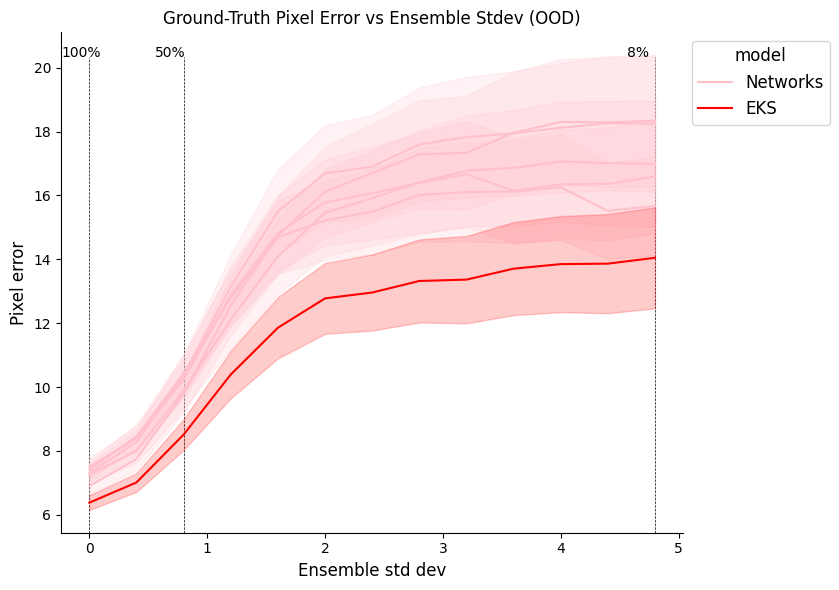

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the color mapping
color_mapping = {
    'networks': 'pink',
    'eks': 'red',
    'ens-mean': 'lightgreen',
    'ens-median': 'green',
    'aeks_hand_rng': 'lightblue',
    'aeks_hand_eks': 'blue',
    'aeks_ens-mean': 'orange',
    'aeks_ens-median': 'red'
}

# Create a color list based on the model names
def get_color(name):
    if 'aeks_ens-median' in name:
        return color_mapping['aeks_ens-median']
    elif 'aeks_ens-mean' in name:
        return color_mapping['aeks_ens-mean']
    elif 'aeks_hand_rng' in name:
        return color_mapping['aeks_hand_rng']
    elif 'aeks_hand_eks' in name:
        return color_mapping['aeks_hand_eks']
    else:
        base_name = name.split('_')[0]
        return color_mapping.get(base_name, 'gray')

palette = [get_color(name) for name in df_line2['model'].unique()]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Increase the figure size

g = sns.lineplot(
    x='ens-std',
    y='mean',
    hue='model',
    hue_order=model_names_list,
    palette=palette,
    data=df_line2,
    ax=ax,
    errorbar='se'
)

labels_fontsize = 12

ax.set_title(f'Ground-Truth Pixel Error vs Ensemble Stdev (OOD)', fontsize=labels_fontsize)
ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
cleanaxis(ax)

# Customize legend
legend_labels = {
    'networks': 'Networks',
    'eks': 'EKS',
    'ens-mean': 'Ensemble Mean',
    'ens-median': 'Ensemble Median',
    'aeks_hand_rng': 'aEKS_hand',
    'aeks_hand_eks': 'aEKS_hand EKS',
    'aeks_ens-mean': 'aEKS Ensemble Mean',
    'aeks_ens-median': 'aEKS Ensemble Median'
}

# Combine similar models into single legend entries
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []

for handle, label in zip(handles, labels):
    if 'aeks_ens-median' in label:
        base_label = 'aeks_ens-median'
    elif 'aeks_ens-mean' in label:
        base_label = 'aeks_ens-mean'
    elif 'aeks_hand_rng' in label:
        base_label = 'aeks_hand_rng'
    elif 'aeks_hand_eks' in label:
        base_label = 'aeks_hand_eks'
    else:
        base_label = label.split('_')[0]

    if base_label not in unique_labels:
        unique_labels.append(base_label)
        unique_handles.append(handle)

ax.legend(
    handles=unique_handles,
    labels=[legend_labels.get(label, label) for label in unique_labels],
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=labels_fontsize,
    title='model',
    title_fontsize=labels_fontsize
)

# Plot annotations
percentiles = [100, 50, 1]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[model_names_list[0]],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=0.5, color='k', zorder=-1)
    ax.text(
        v / np.diff(ax.get_xlim()), 0.95, str(round(p)) + '%',
        transform=ax.transAxes,
        ha='left',
    )

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()
